# Implementing MNIST in PyTorch
In order to learn how to use PyTorch, I'm going to be attempting to follow online tutorials to train a neural net to classify MNIST digits.

### Links
I'll be following a mix of tutorials, but specifically the following ones:
 - https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html (official PyTorch documentation)
 - https://jamesmccaffrey.wordpress.com/2020/05/22/a-minimal-pytorch-complete-example/ (a minimal example written on the iris dataset)


## Initial Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

torch.manual_seed(0)

## Import the MNIST Data
 - `datasets.MNIST` automatically downloads MNIST dataset and puts it in directory of choosing
 - `DataLoader` automatically batches data with chosen batch size

In [ ]:
# Load the datasets
training_data = datasets.MNIST(
    root="data",
    train = True,
    download = True,
    transform = ToTensor(),
)
test_data = datasets.MNIST(
    root="data",
    train = False,
    download = True,
    transform = ToTensor(),
)
# Put dataset into DataLoader
BATCH_SIZE = 64
training_data_loader = DataLoader(
    training_data,
    batch_size = BATCH_SIZE,
)
test_data_loader = DataLoader(
    test_data,
    batch_size = BATCH_SIZE,
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 58.3kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.23MB/s]


In [ ]:
X, y = next(iter(test_data_loader))
print(f"X.shape: {X.shape}, y.shape: {y.shape}")

X.shape: torch.Size([64, 1, 28, 28]), y.shape: torch.Size([64])


## Define the Model
 - we can define model to run on cuda or cpu

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"device: {device}")

# Define our model
# 784 --Sigmoid--> 500 --Sigmoid--> 100 --Sigmoid--> 10
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.network_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    # Feed forward through network
    def forward(self, x):
        # x is initially shape (28,28) so we need to first flatten
        x = self.flatten(x)
        y = self.network_stack(x)
        return y

model = NeuralNetwork().to(device)
print(model)

device: cuda
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Change Model Parameters
 - here we define the loss function
 - mess with learning rate until convergence

In [ ]:
# Add loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

<ipython-input-6-373d4ff1d783>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch, (X, y) in tqdm( enumerate(training_data_loader) ):


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

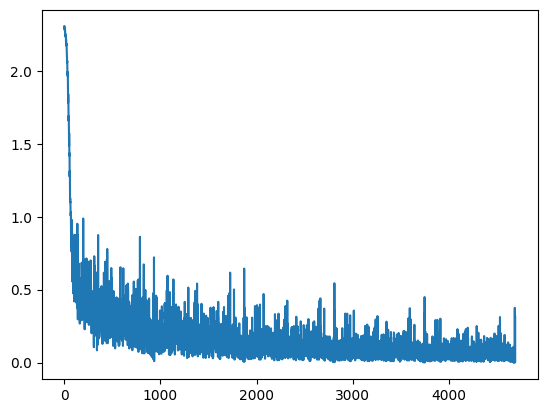

In [ ]:
iters = []; loss_fn_pts = [] # Plotting loss function
# Train the neural network
model.train()
for epoch in range(5):
    for batch, (X, y) in tqdm( enumerate(training_data_loader) ):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # Update pts
        loss_fn_pts.append(loss.item())
        iters.append( 0 if len(iters) == 0 else iters[-1]+1 )
plt.plot(iters, loss_fn_pts)

loss function going down = profit 👍

## Test Model

In [ ]:
accuracies = []
with torch.no_grad():
    model.eval()
    for batch, (X, y) in enumerate(test_data_loader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        curr_accuracies = (pred.argmax(1) == y).cpu().numpy()
        accuracies.append( (sum(curr_accuracies), len(curr_accuracies)) )

print(f"Accuracy: {sum(i[0] for i in accuracies) / sum(i[1] for i in accuracies)}")

Accuracy: 0.9743
